In [25]:
import numpy as np
import keras
import sklearn
import matplotlib.pyplot as plt 
from sklearn.datasets import make_classification
import math

# Quantum libraries

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer, QNGOptimizer, RotosolveOptimizer


In [26]:
def reshape_x(input_array):
    # Calculate the number of subarrays needed
    num_subarrays = len(input_array) // 3 + (len(input_array) % 3 != 0)

    # Split the array into subarrays of size 3
    subarrays = [input_array[i * 3:(i + 1) * 3] for i in range(num_subarrays)]

    # Check if the last subarray has fewer than 3 elements and pad with zeros if necessary
    if len(subarrays[-1]) < 3:
        subarrays[-1] = np.pad(subarrays[-1], (0, 3 - len(subarrays[-1])), mode='constant')
        
    return subarrays

dev = qml.device("lightning.gpu", wires=2)
# Install any pennylane-plugin to run on some particular backend

@qml.qnode(dev, interface="autograd")
# def qcircuit_basic(params, x, y):
#     """A variational quantum circuit representing the Universal classifier.
#     This version follows the Pennylane demo and is a simplified implemenation. 

#     Args:
#         params (array[float]): array of parameters
#         x (array[float]): single input vector
#         y (array[float]): single output state density matrix

#     Returns:
#         float: fidelity between output state and input
#     """
#     for p in params: # Iterate num_layers times
#         for x_sub in x:
#             qml.Rot(*x_sub, wires=0)
#         qml.Rot(*p, wires=0)
#     return qml.expval(qml.Hermitian(y, wires=[0]))

@qml.qnode(dev, interface="autograd")
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.
    This version follows the description of the paper to "incorporate data and processing of angles in a single step"
    
    Args:
        params (array[float]): array of parameters of dim ( num_layers, 2, ceil(len(x)/3)*3 ) 
        x (array[float]): single input vector 
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for l in range(params.shape[0]): # Iterate num_layers times
        # w, b = [], []
        # w.append( params[l, 0]  )  # weight vector
        # b.append( params[l, 1]  )  # bias vector
        # w.append( params[l, 2]  )  # weight vector
        # b.append( params[l, 3]  )  # bias vector
        
        w_0 = params[l, 0]
        b_0 = params[l, 1]
        w_1 = params[l, 2]
        b_1 = params[l, 3]
        
        
        # print('x: ', x)
        # print('x.shape: ', x.shape)
        # print('w.shape: ', w.shape)
        # print('b.shape: ', b.shape)
        
        encoding_0 = w_0 * x + b_0
        encoding_0 = reshape_x(encoding_0)
        
        encoding_1 = w_1 * x + b_1
        encoding_1 = reshape_x(encoding_1)
        
        for i in range(len(encoding_0)):
            qml.Rot(*(encoding_0[i]), wires=0)
            qml.Rot(*(encoding_1[i]), wires=1)
        
        qml.CZ([0, 1]) 
    
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

/home/vishwa/QC/604/quantum-image-classifier/.venv/lib/python3.10/site-packages/pennylane_lightning/lightning_gpu/lightning_gpu.py:958: UserWarning: 
                "Pre-compiled binaries for lightning.gpu are not available. Falling back to "
                "using the Python-based default.qubit implementation. To manually compile from "
                "source, follow the instructions at "
                "https://pennylane-lightning.readthedocs.io/en/latest/installation.html.",
            
  warn(


### Utility functions for testing and creating batches



In [27]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [28]:
# Define output labels as quantum state vectors for binary classification

def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]] # Digit Zero 
label_1 = [[0], [1]] # Digit One
state_labels = np.array([label_0, label_1], requires_grad=False)

In [29]:
def train_q_classifier(n_samples = 500, n_features = 6, n_informative = 2, n_classes = 2, 
                num_layers = 10, learning_rate = 0.6, epochs = 10, batch_size = 32):
    
    # n_samples = 500
    # n_features = 6
    # n_informative = 2
    # n_redundant = 4
    # n_classes = 2
    n_qubits = 2

    # Create a synthetic dataset with 2 classes
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=(n_features - n_informative),
        n_classes=n_classes,
        class_sep=2.,
        random_state=0
    )
    
    # X = np.array(X)
    # y = np.array(y)

    # set training and test data
    split = int(0.8 * n_samples)
    X_train = X[:split, :]
    y_train = y[:split]
    X_test = X[split:, :]
    y_test = y[split:]

    # Train using Adam optimizer and evaluate the classifier
    # num_layers = 10
    # learning_rate = 0.6
    # epochs = 10
    # batch_size = 32

    opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
    # opt = RotosolveOptimizer()

    # initialize random weights
    params = np.random.uniform(size=(num_layers, 2*n_qubits, n_features), requires_grad=True) 


    label_0 = [[1], [0]] # Digit Zero 
    label_1 = [[0], [1]] # Digit One
    state_labels = np.array([label_0, label_1], requires_grad=False)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)

    # save predictions with random weights for comparison
    initial_predictions = predicted_test

    loss = cost(params, X_test, y_test, state_labels)

    print(
        "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
            0, loss, accuracy_train, accuracy_test
        )
    )

    for it in range(epochs):
        for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
            params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

        predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
        accuracy_train = accuracy_score(y_train, predicted_train)
        loss = cost(params, X_train, y_train, state_labels)

        predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
        accuracy_test = accuracy_score(y_test, predicted_test)
        res = [it + 1, loss, accuracy_train, accuracy_test]
        print(
            "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
                *res
            )
        )
        
    return float(accuracy_test)

In [30]:
_ = train_q_classifier(n_features=3, n_informative=2, num_layers=10)

Epoch:  0 | Cost: 0.260333 | Train accuracy: 0.640000 | Test Accuracy: 0.630000
Epoch:  1 | Loss: 0.275341 | Train accuracy: 0.522500 | Test accuracy: 0.570000
Epoch:  2 | Loss: 0.276052 | Train accuracy: 0.552500 | Test accuracy: 0.530000
Epoch:  3 | Loss: 0.289549 | Train accuracy: 0.532500 | Test accuracy: 0.450000
Epoch:  4 | Loss: 0.299924 | Train accuracy: 0.477500 | Test accuracy: 0.480000
Epoch:  5 | Loss: 0.248737 | Train accuracy: 0.615000 | Test accuracy: 0.580000
Epoch:  6 | Loss: 0.292569 | Train accuracy: 0.525000 | Test accuracy: 0.530000
Epoch:  7 | Loss: 0.276847 | Train accuracy: 0.575000 | Test accuracy: 0.490000
Epoch:  8 | Loss: 0.280108 | Train accuracy: 0.555000 | Test accuracy: 0.540000
Epoch:  9 | Loss: 0.270546 | Train accuracy: 0.532500 | Test accuracy: 0.410000
Epoch: 10 | Loss: 0.318731 | Train accuracy: 0.432500 | Test accuracy: 0.480000


# Annulus Problem



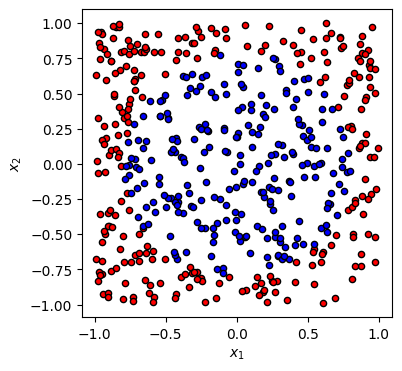

In [31]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt


# Set a random seed
np.random.seed(42)


# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


Xdata, ydata = circle(500)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

Epoch:  0 | Cost: 0.411674 | Train accuracy: 0.520000 | Test Accuracy: 0.477000
Epoch:  1 | Loss: 0.227900 | Train accuracy: 0.600000 | Test accuracy: 0.624500
Cost: 0.227900 | Train accuracy 0.600000 | Test Accuracy : 0.624500
Epoch:  2 | Loss: 0.218866 | Train accuracy: 0.660000 | Test accuracy: 0.638500
Cost: 0.218866 | Train accuracy 0.660000 | Test Accuracy : 0.638500
Epoch:  3 | Loss: 0.177687 | Train accuracy: 0.760000 | Test accuracy: 0.754000
Cost: 0.177687 | Train accuracy 0.760000 | Test Accuracy : 0.754000
Epoch:  4 | Loss: 0.166867 | Train accuracy: 0.795000 | Test accuracy: 0.796000
Cost: 0.166867 | Train accuracy 0.795000 | Test Accuracy : 0.796000
Epoch:  5 | Loss: 0.129415 | Train accuracy: 0.830000 | Test accuracy: 0.853000
Cost: 0.129415 | Train accuracy 0.830000 | Test Accuracy : 0.853000
Epoch:  6 | Loss: 0.157445 | Train accuracy: 0.740000 | Test accuracy: 0.792000
Cost: 0.157445 | Train accuracy 0.740000 | Test Accuracy : 0.792000
Epoch:  7 | Loss: 0.117294 | Tra

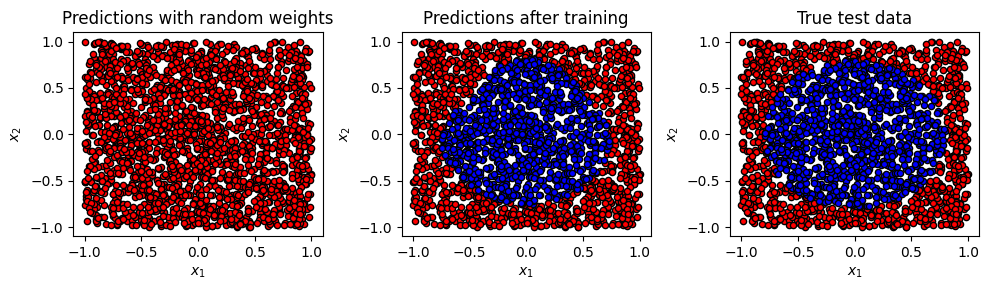

In [33]:
# Generate training and test data
num_training = 200
num_test = 2000

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32
n_features = 3 

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
# params = np.random.uniform(size=(num_layers, 3), requires_grad=True)
params = np.random.uniform(size=(num_layers, 2*2, n_features), requires_grad=True) 


predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )
    
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("\n\nLearned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()